In [1]:
%load_ext autoreload
%autoreload 2
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig, AutoTokenizer
from omegaconf import OmegaConf
import hydra
from einops import repeat
import pyvene as pv
import torch
import wandb
from tasks.regression import *
import os
import gc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Note
Doesn't include Alchemy interpretability experiments, which unfortunately didn't get integrated into this repo yet (they were done in an other one). However they should be very easy to do by extending the code here.

# Sandbox

In [2]:
experiments = {
    "explicit-transformer": "1ejrnua7",
    "explicit-mlp": "hb9li9ry",
    "explicit-aux-transformer": "hzr77fqz",
    "implicit": "huqr2bcp",
}

In [33]:
EXP = 'implicit'

In [34]:
api = wandb.Api()
run = api.run(f'leogagnon/Explicit-Implicit/runs/{experiments[EXP]}')
artifact = api.artifact(f'leogagnon/Explicit-Implicit/model-{experiments[EXP]}:latest')
path = artifact.download()

wandb:   1 of 1 files downloaded.  


In [35]:
pl_module = RegressionICL.load_from_checkpoint(
    checkpoint_path=os.path.join(path,'model.ckpt'),
    strict=False,
    model=hydra.utils.instantiate(run.config['model_config']),
).to('cuda')

In [36]:
class MyConfig(PretrainedConfig):
    model_type = 'mymodel'
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

class MyModel(PreTrainedModel):
    config_class = MyConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = pl_module.model
    def forward(self, x_c, y_c, x_q):
        return self.model(x_c, y_c, x_q) 

In [37]:
[i for i in range(2) for j in range(2)]

[0, 0, 1, 1]

In [38]:
hf_model = MyModel(MyConfig())
if EXP == "implicit":
    pv_config = pv.IntervenableConfig(
        representations=[
            pv.RepresentationConfig(
                component=f"model.encoder.layers[{l}].output",
                intervention=pv.LowRankRotatedSpaceIntervention(
                    embed_dim=256, low_rank_dimension=10, keep_last_dim=True
                ),
            )
            for l in [2,3,5]
        ]
    )
else:
    pv_config = pv.IntervenableConfig(
        representations=pv.RepresentationConfig(
            component="model.context_model.output",
            intervention=pv.LowRankRotatedSpaceIntervention(
                embed_dim=256, low_rank_dimension=10
            ),
        )
    )
pv_model = pv.IntervenableModel(config=pv_config, model=hf_model)
pv_model.set_device("cuda")

In [39]:
datamodule = hydra.utils.instantiate(run.config['experiment_config']['experiment']['data'])

In [40]:
val_idx = {'iid': 0, 'far': 1, 'wide': 2}
VAL_STYLE = 'wide'

In [41]:
opt = torch.optim.Adam(pv_model.get_trainable_parameters())
pv_model.model.eval()

train_loss_traj = []
val_loss_traj = []
for epoch in range(20):
    train_loss = []
    for batch in datamodule.train_dataloader():
        base = {
            "x_c": batch[0][0].cuda(),
            "y_c": batch[0][1].cuda(),
            "x_q": batch[1][0].cuda(),
        }
        c_len = batch[0][0].shape[1]
        bs = batch[0][0].shape[0]

        # Different context, different queries, different latent
        x_c_source, x_q_source = datamodule.train_data.sample_x(c_len)
        w_source = datamodule.train_data.sample_function_params()
        source = {
            "x_c": x_c_source.cuda(),
            "y_c": datamodule.train_data.function(x_c_source, w_source).cuda(),
            "x_q": batch[1][0].cuda(),
        }
        loc = [[[[(c_len + i) for i in range(c_len)]] * bs] * 3] * 2
        unit_locations = {"sources->base": loc} if EXP == "implicit" else None
        y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
        y_q_counterfactual = datamodule.train_data.function(
            batch[1][0], w_source
        ).cuda()

        loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)

        loss.backward()
        train_loss += [loss.detach().cpu().item()]
        opt.step()
        opt.zero_grad()

    train_loss_traj += [sum(train_loss) / len(train_loss)]
    print("Train loss :", train_loss_traj[-1])

    with torch.no_grad():
        for batch in datamodule.val_dataloader()[val_idx[VAL_STYLE]]:
            gc.collect()
            base = {
                "x_c": batch[0][0].cuda(),
                "y_c": batch[0][1].cuda(),
                "x_q": batch[1][0].cuda(),
            }
            c_len = batch[0][0].shape[1]
            bs = batch[0][0].shape[0]

            # Different context, different queries, different latent
            x_c_source, x_q_source = datamodule.val_data[VAL_STYLE].sample_x(
                batch[0][0].shape[1]
            )
            w_source = datamodule.val_data[VAL_STYLE].sample_function_params()
            source = {
                "x_c": x_c_source.cuda(),
                "y_c": datamodule.val_data[VAL_STYLE]
                .function(x_c_source, w_source)
                .cuda(),
                "x_q": batch[1][0].cuda(),
            }

            loc = [[[[(c_len + i) for i in range(c_len)]] * bs] * 3] * 2
            unit_locations = {"sources->base": loc} if EXP == "implicit" else None
            y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
            y_q_counterfactual = (
                datamodule.val_data[VAL_STYLE].function(batch[1][0], w_source).cuda()
            )

            loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)
            val_loss_traj += [loss.cpu().item()]
            print("Val loss :", loss)

Train loss : 2.360770344734192
Val loss : tensor(4.6505, device='cuda:0')
Train loss : 0.5791825907570975
Val loss : tensor(2.1302, device='cuda:0')
Train loss : 0.2606759603534426
Val loss : tensor(1.7268, device='cuda:0')
Train loss : 0.14732533480439866
Val loss : tensor(1.5393, device='cuda:0')
Train loss : 0.10062737337180547
Val loss : tensor(1.3253, device='cuda:0')
Train loss : 0.07483400404453278
Val loss : tensor(1.3590, device='cuda:0')
Train loss : 0.06655098018901688
Val loss : tensor(1.0370, device='cuda:0')
Train loss : 0.04967491488371577
Val loss : tensor(1.0519, device='cuda:0')
Train loss : 0.051599811762571335
Val loss : tensor(1.0727, device='cuda:0')
Train loss : 0.03970677964389324
Val loss : tensor(0.9081, device='cuda:0')
Train loss : 0.03521640492337091
Val loss : tensor(0.7734, device='cuda:0')
Train loss : 0.026427481855664934
Val loss : tensor(0.7373, device='cuda:0')
Train loss : 0.027114037158233777
Val loss : tensor(0.7432, device='cuda:0')
Train loss : 

In [24]:
implicit_mse = val_loss_traj[-1]

In [36]:
explicitMLP_mse = val_loss_traj[-1]

In [44]:
explicitTSF_mse = val_loss_traj[-1]

In [45]:
counterfactual_mse = [implicit_mse, explicitTSF_mse, explicitMLP_mse]

# Figures

In [2]:
experiments = {
    "explicit-transformer": "1ejrnua7",
    "explicit-mlp": "hb9li9ry",
    "explicit-aux-transformer": "hzr77fqz",
    "implicit": "huqr2bcp",
}
val_idx = {'iid': 0, 'far': 1, 'wide': 2}


def val_intervention_acc(val_style, exp):

    api = wandb.Api()
    run = api.run(f'leogagnon/Explicit-Implicit/runs/{experiments[exp]}')
    artifact = api.artifact(f'leogagnon/Explicit-Implicit/model-{experiments[exp]}:latest')
    path = artifact.download()

    pl_module = RegressionICL.load_from_checkpoint(
        checkpoint_path=os.path.join(path,'model.ckpt'),
        strict=False,
        model=hydra.utils.instantiate(run.config['model_config']),
    ).to('cuda')

    class MyConfig(PretrainedConfig):
        model_type = 'mymodel'
        def __init__(self, **kwargs):
            super().__init__(**kwargs)

    class MyModel(PreTrainedModel):
        config_class = MyConfig
        def __init__(self, config):
            super().__init__(config)
            self.config = config
            self.model = pl_module.model
        def forward(self, x_c, y_c, x_q):
            return self.model(x_c, y_c, x_q) 

    hf_model = MyModel(MyConfig())
    if exp == "implicit":
        pv_config = pv.IntervenableConfig(
            representations=[
                pv.RepresentationConfig(
                    component=f"model.encoder.layers[{i}].output",
                    intervention=pv.LowRankRotatedSpaceIntervention(
                        embed_dim=256, low_rank_dimension=10
                    )
                )
                for i in [3,5]
            ]
        )
    else:
        pv_config = pv.IntervenableConfig(
            representations=pv.RepresentationConfig(
                component="model.context_model.output",
                intervention=pv.LowRankRotatedSpaceIntervention(
                    embed_dim=256, low_rank_dimension=10
                ),
            )
        )
    pv_model = pv.IntervenableModel(config=pv_config, model=hf_model)
    pv_model.set_device("cuda")

    datamodule = hydra.utils.instantiate(run.config['experiment_config']['experiment']['data'])

    opt = torch.optim.Adam(pv_model.get_trainable_parameters())
    pv_model.model.eval()

    train_loss_traj = []
    val_loss_traj = []
    for epoch in range(10):
        train_loss = []
        for batch in datamodule.train_dataloader():
            base = {
                "x_c": batch[0][0].cuda(),
                "y_c": batch[0][1].cuda(),
                "x_q": batch[1][0].cuda(),
            }
            c_len = batch[0][0].shape[1]

            # Different context, different queries, different latent
            x_c_source, x_q_source = datamodule.train_data.sample_x(c_len)
            w_source = datamodule.train_data.sample_function_params()
            source = {
                "x_c": x_c_source.cuda(),
                "y_c": datamodule.train_data.function(x_c_source, w_source).cuda(),
                "x_q": x_q_source.cuda(),
            }
            unit_locations = (
                {"sources->base": c_len - 1}
                if exp == "implicit"
                else None
            )
            y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
            y_q_counterfactual = datamodule.train_data.function(
                batch[1][0], w_source
            ).cuda()

            loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)

            loss.backward()
            train_loss += [loss.detach().cpu().item()]
            opt.step()
            opt.zero_grad()

        train_loss_traj += [sum(train_loss) / len(train_loss)]
        print("Train loss :", train_loss_traj[-1])
        
        with torch.no_grad():
            for batch in datamodule.val_dataloader()[val_idx[val_style]]:
                gc.collect()
                base = {
                    "x_c": batch[0][0].cuda(),
                    "y_c": batch[0][1].cuda(),
                    "x_q": batch[1][0].cuda(),
                }
                c_len = batch[0][0].shape[1]
                bs = batch[0][0].shape[0]

                # Different context, different queries, different latent
                x_c_source, x_q_source = datamodule.val_data[val_style].sample_x(
                    batch[0][0].shape[1]
                )
                w_source = datamodule.val_data[val_style].sample_function_params()
                source = {
                    "x_c": x_c_source.cuda(),
                    "y_c": datamodule.val_data[val_style].function(x_c_source, w_source).cuda(),
                    "x_q": x_q_source.cuda(),
                }

                unit_locations = (
                    {"sources->base": c_len - 1}
                    if exp == "implicit"
                    else None
                )
                y_q_intervened = pv_model(base, source, unit_locations=unit_locations)[1][0]
                y_q_counterfactual = (
                    datamodule.val_data[val_style].function(batch[1][0], w_source).cuda()
                )

                loss = torch.nn.functional.mse_loss(y_q_intervened, y_q_counterfactual)
                val_loss_traj += [loss.cpu().item()]
                print("Val loss :", loss)
    return val_loss_traj[-1]

In [3]:
accs = torch.zeros(2,3)

In [4]:
for i, v in enumerate(["iid", "wide"]):
    for j, e in enumerate(["implicit", "explicit-transformer", "explicit-mlp"]):
        accs[i, j] = val_intervention_acc(v, e)

wandb:   1 of 1 files downloaded.  


Train loss : 4.011986323765346
Val loss : tensor(4.0815, device='cuda:0')
Train loss : 4.0267515523093085
Val loss : tensor(3.7923, device='cuda:0')
Train loss : 3.7273685250963484
Val loss : tensor(3.9347, device='cuda:0')
Train loss : 3.764397621154785
Val loss : tensor(3.7408, device='cuda:0')
Train loss : 3.9189292703356062
Val loss : tensor(3.7784, device='cuda:0')
Train loss : 3.5216233049120222
Val loss : tensor(3.9024, device='cuda:0')
Train loss : 3.4636666093553816
Val loss : tensor(3.7788, device='cuda:0')
Train loss : 3.679075138909476
Val loss : tensor(3.9416, device='cuda:0')
Train loss : 3.765798943383353
Val loss : tensor(3.7384, device='cuda:0')
Train loss : 3.8335113865988597
Val loss : tensor(3.8138, device='cuda:0')


wandb:   1 of 1 files downloaded.  
/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['w_predictor.weight', 'w_predictor.bias']


Train loss : 3.353935854775565
Val loss : tensor(2.3136, device='cuda:0')
Train loss : 1.5687673687934875
Val loss : tensor(0.7912, device='cuda:0')
Train loss : 0.49709790519305636
Val loss : tensor(0.2838, device='cuda:0')
Train loss : 0.270723500422069
Val loss : tensor(0.2029, device='cuda:0')
Train loss : 0.14807628840208054
Val loss : tensor(0.1374, device='cuda:0')
Train loss : 0.09683113119431905
Val loss : tensor(0.0833, device='cuda:0')
Train loss : 0.08076975015657288
Val loss : tensor(0.0599, device='cuda:0')
Train loss : 0.04992461603667055
Val loss : tensor(0.0350, device='cuda:0')
Train loss : 0.03285386652818748
Val loss : tensor(0.0270, device='cuda:0')
Train loss : 0.024085753464273045
Val loss : tensor(0.0233, device='cuda:0')


wandb:   1 of 1 files downloaded.  


Train loss : 3.213998453957694
Val loss : tensor(2.0095, device='cuda:0')
Train loss : 1.3852025355611528
Val loss : tensor(0.6147, device='cuda:0')
Train loss : 0.35411433024065836
Val loss : tensor(0.1255, device='cuda:0')
Train loss : 0.08807630730526787
Val loss : tensor(0.0509, device='cuda:0')
Train loss : 0.03985041167054858
Val loss : tensor(0.0335, device='cuda:0')
Train loss : 0.030730745622089932
Val loss : tensor(0.0262, device='cuda:0')
Train loss : 0.030964125746062825
Val loss : tensor(0.0217, device='cuda:0')
Train loss : 0.023663979821971486
Val loss : tensor(0.0237, device='cuda:0')
Train loss : 0.019314085133373737
Val loss : tensor(0.0218, device='cuda:0')
Train loss : 0.019389699612345015
Val loss : tensor(0.0204, device='cuda:0')


wandb:   1 of 1 files downloaded.  


Train loss : 3.958805969783238
Val loss : tensor(19.6652, device='cuda:0')
Train loss : 4.013682195118496
Val loss : tensor(17.6033, device='cuda:0')
Train loss : 3.828946692602975
Val loss : tensor(19.3740, device='cuda:0')
Train loss : 3.935387441090175
Val loss : tensor(17.7048, device='cuda:0')
Train loss : 3.7977961131504605
Val loss : tensor(16.7834, device='cuda:0')
Train loss : 3.647902079990932
Val loss : tensor(18.0866, device='cuda:0')
Train loss : 3.705806085041591
Val loss : tensor(18.0124, device='cuda:0')
Train loss : 3.642932210649763
Val loss : tensor(18.2731, device='cuda:0')
Train loss : 3.545614617211478
Val loss : tensor(17.8491, device='cuda:0')
Train loss : 3.7123308181762695
Val loss : tensor(19.4399, device='cuda:0')


wandb:   1 of 1 files downloaded.  


Train loss : 2.980156489780971
Val loss : tensor(10.2945, device='cuda:0')
Train loss : 1.5150172369820731
Val loss : tensor(4.4984, device='cuda:0')
Train loss : 0.5487140885421208
Val loss : tensor(1.9907, device='cuda:0')
Train loss : 0.2968717111008508
Val loss : tensor(1.1654, device='cuda:0')
Train loss : 0.1644017579300063
Val loss : tensor(1.0068, device='cuda:0')
Train loss : 0.10467793260301862
Val loss : tensor(0.7604, device='cuda:0')
Train loss : 0.06545557560665267
Val loss : tensor(0.5530, device='cuda:0')
Train loss : 0.040172119225774496
Val loss : tensor(0.6879, device='cuda:0')
Train loss : 0.03454030491411686
Val loss : tensor(0.5391, device='cuda:0')
Train loss : 0.025990590187055723
Val loss : tensor(0.4927, device='cuda:0')


wandb:   1 of 1 files downloaded.  


Train loss : 2.603308234895979
Val loss : tensor(9.2331, device='cuda:0')
Train loss : 1.1734027777399336
Val loss : tensor(2.9120, device='cuda:0')
Train loss : 0.2634147820728166
Val loss : tensor(0.8750, device='cuda:0')
Train loss : 0.07445224480969566
Val loss : tensor(0.4984, device='cuda:0')
Train loss : 0.037031687263931544
Val loss : tensor(0.3702, device='cuda:0')
Train loss : 0.0340986294405801
Val loss : tensor(0.4231, device='cuda:0')
Train loss : 0.028618727943726947
Val loss : tensor(0.3366, device='cuda:0')
Train loss : 0.02741645516029426
Val loss : tensor(0.2522, device='cuda:0')
Train loss : 0.02366162756724017
Val loss : tensor(0.3373, device='cuda:0')
Train loss : 0.02618378959596157
Val loss : tensor(0.3358, device='cuda:0')


In [5]:
data = pd.melt(
    pd.DataFrame(accs).reset_index(),
    id_vars="index",
    var_name="Model",
    value_name="value",
)
data.rename(columns={"index": "OOD style"}, inplace=True)
data.rename(columns={"value": "Counterfactual MSE"}, inplace=True)

data['Model'] = data['Model'].map({0: 'Implicit', 1: 'Explicit Transformer', 2: 'Explicit MLP'})
data['OOD style'] = data['OOD style'].map({0: 'IID', 1: 'OOD',})

In [6]:
# Style for making nice-looking paper plots with page-scale figure size units
sns.set_theme(
    style="ticks",
    context="paper",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)

/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mila/l/leo.gagnon/explicit_implicit_icl/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

(0.0, 10.0)

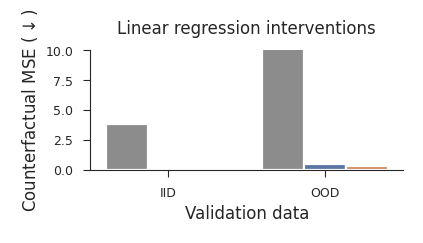

In [7]:
default_model_colours = {
    "implicit": sns.color_palette()[7],
    "explicit-transformer": sns.color_palette()[0],
    "explicit-mlp": sns.color_palette()[1],
    "explicit-aux-transformer": sns.color_palette()[4],
    "explicit-known": sns.color_palette()[2],
}

fig, ax = plt.subplots(figsize=(2, 1.1))

sns.barplot(
    data=data,
    ax=ax,
    x="OOD style",
    y="Counterfactual MSE",
    hue="Model",
    hue_order=["Implicit", "Explicit Transformer", "Explicit MLP"],
    palette=[
        default_model_colours[m]
        for m in ["implicit", "explicit-transformer", "explicit-mlp"]
    ],
    err_kws={"linewidth": 1.25},
)
ax.legend().remove()
ax.set(
    title="Linear regression interventions",
    xlabel="Validation data",
    ylabel=r"Counterfactual MSE ($\downarrow$)",
)
ax.set_ylim([0,10])

In [9]:
plt.savefig('xd.pdf')

<Figure size 1280x960 with 0 Axes>

In [10]:
fig.savefig('linreg_intv.pdf')